<font size=6>
    <b>Sentiment_Analysis.ipynb:</b> Sentiment Analysis with Pandas and Watson Natural Language Understanding
 </font>

# Introduction

With the significant growth in the volume of highly subjective user-generated text in the form of online products reviews, recommendations, blogs, discussion forums and etc., the sentiment analysis has gained a lot of attention in the last decade. The sentiment analysis goal is to automatically detect the underlying sentiment of the user towards the entity of interest. While the Sentiment analysis is  one of the most prominent and commonly used natural language processing (NLP) features, it is typically used in combination with other NLP features and text analytics to gain insight about the user experience for the sake of customer care and feedback analytics, product analytics and brand intelligence.
This notebook shows how the open source library [Text Extensions for Pandas](https://github.com/CODAIT/text-extensions-for-pandas) lets you use use [Pandas](https://pandas.pydata.org/) DataFrames and the [Watson Natural Language Understanding](https://www.ibm.com/cloud/watson-natural-language-understanding) service to conduct exploratory sentiment analysis over the product reviews. 

We start out with a dataset from the [Edmunds-Consumer Car Ratings and Reviews](https://www.kaggle.com/ankkur13/edmundsconsumer-car-ratings-and-reviews) obtained from the Kaggle datasets. This is a dataset containing consumer's thought and the star rating of car manufacturer/model/type.
We pass each review to the Watson Natural Language 
Understanding (NLU) service. Then we use Text Extensions for Pandas to convert the output of the 
Watson NLU service to Pandas DataFrames. Next, we perform an example exploratory data analysis and machine learning task with 
Pandas to show how Pandas makes analyzing the dataset and prediction task much easier.

# Environment Setup

This notebook requires a Python 3.7 or later environment with the following packages:
* The dependencies listed in the ["requirements.txt" file for Text Extensions for Pandas](https://github.com/CODAIT/text-extensions-for-pandas/blob/master/requirements.txt)
* The "[ibm-watson](https://pypi.org/project/ibm-watson/)" package, available via `pip install ibm-watson`
* `text_extensions_for_pandas`

You can satisfy the dependency on `text_extensions_for_pandas` in either of two ways:

* Run `pip install text_extensions_for_pandas` before running this notebook. This command adds the library to your Python environment.
* Run this notebook out of your local copy of the Text Extensions for Pandas project's [source tree](https://github.com/CODAIT/text-extensions-for-pandas). In this case, the notebook will use the version of Text Extensions for Pandas in your local source tree **if the package is not installed in your Python environment**.

In [1]:
# Core Python libraries
import json
import os
import sys
import pandas as pd
import numpy as np
import glob
import re
import time
import warnings
from typing import *

# IBM Watson libraries
import ibm_watson
import ibm_watson.natural_language_understanding_v1 as nlu
import ibm_cloud_sdk_core

# Machine Learning libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Visualization
import matplotlib.pyplot as plt


# And of course we need the text_extensions_for_pandas library itself.
try:
    import text_extensions_for_pandas as tp
except ModuleNotFoundError as e:
    # If we're running from within the project source tree and the parent Python
    # environment doesn't have the text_extensions_for_pandas package, use the
    # version in the local source tree.
    if not os.getcwd().endswith("notebooks"):
        raise e
    if ".." not in sys.path:
        sys.path.insert(0, "..")
    import text_extensions_for_pandas as tp

# Set up the Watson Natural Language Understanding Service

In this part of the notebook, we will use the Watson Natural Language Understanding (NLU) service to extract the keywords and their sentiment and emotion from each of the product reviews.

You can create an instance of Watson NLU on the IBM Cloud for free by navigating to [this page](https://www.ibm.com/cloud/watson-natural-language-understanding) and clicking on the button marked "Get started free". You can also install your own instance of Watson NLU on [OpenShift](https://www.openshift.com/) by using [IBM Watson Natural Language Understanding for IBM Cloud Pak for Data](
https://catalog.redhat.com/software/operators/detail/5e9873e13f398525a0ceafe5).

You'll need two pieces of information to access your instance of Watson NLU: An **API key** and a **service URL**. If you're using Watson NLU on the IBM Cloud, you can find your API key and service URL in the IBM Cloud web UI. Navigate to the [resource list](https://cloud.ibm.com/resources) and click on your instance of Natural Language Understanding to open the management UI for your service. Then click on the "Manage" tab to show a page with your API key and service URL.

The cell that follows assumes that you are using the environment variables `IBM_API_KEY` and `IBM_SERVICE_URL` to store your credentials. If you're running this notebook in Jupyter on your laptop, you can set these environment variables while starting up `jupyter notebook` or `jupyter lab`. For example:
``` console
IBM_API_KEY='<my API key>' \
IBM_SERVICE_URL='<my service URL>' \
  jupyter lab
```

Alternately, you can uncomment the first two lines of code below to set the `IBM_API_KEY` and `IBM_SERVICE_URL` environment variables directly.
**Be careful not to store your API key in any publicly-accessible location!**

In [2]:
# If you need to embed your credentials inline, uncomment the following two lines and
# paste your credentials in the indicated locations.
# os.environ["IBM_API_KEY"] = "<API key goes here>"
# os.environ["IBM_SERVICE_URL"] = "<Service URL goes here>"

# Retrieve the API key for your Watson NLU service instance
if "IBM_API_KEY" not in os.environ:
    raise ValueError("Expected Watson NLU api key in the environment variable 'IBM_API_KEY'")
api_key = os.environ.get("IBM_API_KEY")
    
# Retrieve the service URL for your Watson NLU service instance
if "IBM_SERVICE_URL" not in os.environ:
    raise ValueError("Expected Watson NLU service URL in the environment variable 'IBM_SERVICE_URL'")
service_url = os.environ.get("IBM_SERVICE_URL")  

# Connect to the Watson Natural Language Understanding Python API

This notebook uses the IBM Watson Python SDK to perform authentication on the IBM Cloud via the 
`IAMAuthenticator` class. See [the IBM Watson Python SDK documentation](https://github.com/watson-developer-cloud/python-sdk#iam) for more information. 

We start by using the API key and service URL from the previous cell to create an instance of the
Python API for Watson NLU.

In [3]:
natural_language_understanding = ibm_watson.NaturalLanguageUnderstandingV1(
    version="2019-07-12",
    authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(api_key)
)
natural_language_understanding.set_service_url(service_url)
natural_language_understanding.set_disable_ssl_verification(True)

# Pass a Review through the Watson NLU Service

Once you've opened a connection to the Watson NLU service, you can pass documents through 
the service by invoking the [`analyze()` method](https://cloud.ibm.com/apidocs/natural-language-understanding?code=python#analyze).

To do so, you should download the [Edmunds-Consumer Car Ratings and Reviews](https://www.kaggle.com/ankkur13/edmundsconsumer-car-ratings-and-reviews/download/) from the Kaggle website and place the archive.zip folder to our notebooks/outputs directory. Note that the directory of the dataset contains 50 csv files of reviews of 50 major car brands which we read into one dataframe with the brand name is listed under the "Car_Make" column.

Let's read the reviews and show what the reviews looks like:

In [4]:
from zipfile import ZipFile
path = r'./outputs/archive' # path to compressed  directory of data

with ZipFile(path+'.zip', 'r') as zipObj:
   # Extract all the contents of zip file in the notebooks/output/archive directory
   zipObj.extractall(path)
    
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=0, header=0, lineterminator='\n')
    df['Car_Make'] = re.split('_|\\.',os.path.basename(filename))[-2] # Extracting the car brand from file name
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
frame.head(10)

,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating\r,Car_Make
0,on 09/18/11 00:19 AM (PDT),wizbang_fl,2007 Volkswagen New Beetle Convertible 2.5 2dr...,"New Beetle- Holds up well & Fun to Drive, but ...",I've had my Beetle Convertible for over 4.5 y...,4.500,Volkswagen
1,on 07/07/10 05:28 AM (PDT),carlo frazzano,2007 Volkswagen New Beetle Convertible 2.5 PZE...,Quality Review,We bought the car new in 2007 and are general...,4.375,Volkswagen
2,on 10/19/09 21:41 PM (PDT),NewBeetleDriver,2007 Volkswagen New Beetle Convertible Triple ...,Adore it,I adore my New Beetle. Even though I'm a male...,4.375,Volkswagen
3,on 01/01/09 19:13 PM (PST),Kayemtee,2007 Volkswagen New Beetle Convertible 2.5 2dr...,Nice Ragtop,My wife chose this car to replace a Sebring c...,4.375,Volkswagen
4,on 08/02/08 13:43 PM (PDT),jik,2007 Volkswagen New Beetle Convertible 2.5 2dr...,"Luv, luv, luv my dream car",4 of us carpool 1 way 30 min. Backseat ok fo...,4.750,Volkswagen
5,on 05/16/08 12:07 PM (PDT),Ray Cavanagh,2007 Volkswagen New Beetle Convertible Triple ...,The Best One So Far....,I owned a 2002 SLK and 2003 BMW Z-4. After s...,5.000,Volkswagen
6,on 03/28/08 22:04 PM (PDT),harvestmoon,2007 Volkswagen New Beetle Convertible 2.5 2dr...,Don't Fall Under The Cute Spell!,Fell in love with the car's look and would be...,2.750,Volkswagen
7,on 01/03/08 17:53 PM (PST),The Husband,2007 Volkswagen New Beetle Convertible Triple ...,Not for Cold Weather!!!,The car is beautiful and performs well in the...,3.750,Volkswagen
8,on 09/27/07 08:42 AM (PDT),Kristina,2007 Volkswagen New Beetle Convertible 2.5 2dr...,I love my Beetle,I love my car. I previously owned an Explore...,5.000,Volkswagen
9,on 08/01/07 22:24 PM (PDT),bug lover,2007 Volkswagen New Beetle Convertible Triple ...,Bug lover review,"My 2005 was so good, I had to have the Triple...",5.000,Volkswagen


Let's see how many car models, reviews and reviewers and etc. we have per car make in our dataset:

In [5]:
frame.groupby('Car_Make').nunique()

,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating\r
Car_Make,,,,,,
AMGeneral,5,5,2,5,5,4
Acura,5632,5807,494,5682,6512,32
AlfaRomeo,77,76,22,77,77,5
AstonMartin,82,89,31,89,89,17
Audi,5069,5389,753,5467,6006,33
BMW,6833,7106,829,7203,7984,33
Bentley,150,146,39,141,150,21
Bugatti,9,9,4,9,9,7
Buick,3406,3242,374,3334,3615,33


And number of the car makes:

In [6]:
frame.groupby('Car_Make').nunique().shape[0]

50

Let's then sample randomly from the dataframe by keeping <=200 of the records per car make:

In [7]:
n = 200
sampled_df = frame.groupby('Car_Make').apply(lambda x: x.sample(min(n,len(x)))).reset_index(drop=True)
sampled_df.nunique()

Review_Date      7239
Author_Name      7410
Vehicle_Title    5198
Review_Title     7648
Review           8341
Rating\r           33
Car_Make           50
dtype: int64

Checking the number of reviews and columns in the imported corpus:

In [8]:
sampled_df.shape

(8392, 7)

Let's combine the review titles and the review into the review_content for the later analysis:

In [9]:
sampled_df['Review_Content'] = sampled_df['Review_Title']+ ':' + sampled_df['Review']
sampled_df.head()

,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating\r,Car_Make,Review_Content
0,on 08/30/02 00:00 AM (PDT),bluice3309,2000 AM General Hummer SUV 4dr SUV AWD,a true ride,this beast can go through just about \ranythi...,4.625,AMGeneral,a true ride: this beast can go through just ab...
1,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.000,AMGeneral,What a waste: I have owned this car for a year...
2,on 12/18/05 19:55 PM (PST),Clayton,2000 AM General Hummer SUV 4dr SUV AWD,HUMMER NOT A bummer,Vehicle is a beast. I don't recommend HUMMER ...,5.000,AMGeneral,HUMMER NOT A bummer : Vehicle is a beast. I do...
3,on 08/23/03 00:00 AM (PDT),Bobby Keene,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,H1 Review,The truck is incredible. I have a long histo...,4.500,AMGeneral,H1 Review: The truck is incredible. I have a ...
4,on 01/19/06 19:46 PM (PST),REUBEN,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,AWESOME HUMMER,Hummer is unstoppable. May only get 12 mpg bu...,5.000,AMGeneral,AWESOME HUMMER: Hummer is unstoppable. May onl...


Let's see what the reiews look like in our dataset by showing one:

In [10]:
sampled_df['Review_Content'][0]

'a true ride: this beast can go through just about \ranything you through at it. water, \rfire, brick wall, glass ,ice , you name \rit.  i like my toys to be tough enough \rto handle what i through at them.  and \rthis toy has NOT let me down and i do \rnot think it ever will!!!'

# Watson Natural Language Understanding Analysis:
Now it is time to check how Watson Natural Language Understanding can help us analyzing the reviews starting from the first review:

In the code below, we instruct Watson Natural Language Understanding to perform keywords (with sentiment and emotion) analysis on the first review:

See [the Watson NLU documentation](https://cloud.ibm.com/apidocs/natural-language-understanding?code=python#text-analytics-features) for a full description of the types of analysis that NLU can perform.

In [11]:
warnings.filterwarnings('ignore')
# Using Watson Natural Language Understanding for analyzing the Review_Content
# Make the request
nlu_response_review = natural_language_understanding.analyze(
    text=sampled_df['Review_Content'][0],
    return_analyzed_text=True,
    features=nlu.Features(
        keywords=nlu.KeywordsOptions(sentiment=True, emotion=True)
    )).get_result()


The response from the analyze() method is a Python dictionary. The dictionary contains an entry for each pass of analysis requested, plus some additional entries with metadata about the API request itself. Here's a list of the keys in response:

In [12]:
nlu_response_review.keys()

dict_keys(['usage', 'language', 'keywords', 'analyzed_text'])

And here's the whole output of Watson NLU's text analysis for the first review in the dataset:

In [13]:
nlu_response_review

{'usage': {'text_units': 1, 'text_characters': 272, 'features': 1},
 'language': 'en',
 'keywords': [{'text': 'brick wall',
   'sentiment': {'score': 0, 'label': 'neutral'},
   'relevance': 0.929032,
   'emotion': {'sadness': 0.29279,
    'joy': 0.230829,
    'fear': 0.175379,
    'disgust': 0.180316,
    'anger': 0.225414},
   'count': 1},
  {'text': 'true ride',
   'sentiment': {'score': 0.863267, 'label': 'positive'},
   'relevance': 0.900583,
   'emotion': {'sadness': 0.219645,
    'joy': 0.593742,
    'fear': 0.087546,
    'disgust': 0.037523,
    'anger': 0.08835},
   'count': 1},
  {'text': 'fire',
   'sentiment': {'score': 0, 'label': 'neutral'},
   'relevance': 0.678235,
   'emotion': {'sadness': 0.29279,
    'joy': 0.230829,
    'fear': 0.175379,
    'disgust': 0.180316,
    'anger': 0.225414},
   'count': 1},
  {'text': 'toys',
   'sentiment': {'score': -0.738776, 'label': 'negative'},
   'relevance': 0.632428,
   'emotion': {'sadness': 0.308881,
    'joy': 0.49626,
    'fea

Let's explore the output dictionary based on its keys:

In [14]:
nlu_response_review['analyzed_text']

'a true ride: this beast can go through just about \ranything you through at it. water, \rfire, brick wall, glass ,ice , you name \rit.  i like my toys to be tough enough \rto handle what i through at them.  and \rthis toy has NOT let me down and i do \rnot think it ever will!!!'

In [15]:
nlu_response_review['keywords']

[{'text': 'brick wall',
  'sentiment': {'score': 0, 'label': 'neutral'},
  'relevance': 0.929032,
  'emotion': {'sadness': 0.29279,
   'joy': 0.230829,
   'fear': 0.175379,
   'disgust': 0.180316,
   'anger': 0.225414},
  'count': 1},
 {'text': 'true ride',
  'sentiment': {'score': 0.863267, 'label': 'positive'},
  'relevance': 0.900583,
  'emotion': {'sadness': 0.219645,
   'joy': 0.593742,
   'fear': 0.087546,
   'disgust': 0.037523,
   'anger': 0.08835},
  'count': 1},
 {'text': 'fire',
  'sentiment': {'score': 0, 'label': 'neutral'},
  'relevance': 0.678235,
  'emotion': {'sadness': 0.29279,
   'joy': 0.230829,
   'fear': 0.175379,
   'disgust': 0.180316,
   'anger': 0.225414},
  'count': 1},
 {'text': 'toys',
  'sentiment': {'score': -0.738776, 'label': 'negative'},
  'relevance': 0.632428,
  'emotion': {'sadness': 0.308881,
   'joy': 0.49626,
   'fear': 0.157411,
   'disgust': 0.011575,
   'anger': 0.090552},
  'count': 1},
 {'text': 'toy',
  'sentiment': {'score': -0.941767, 'la

For many data scientists and machine learning engineers a common task workflow includes using Pandas to do exploratory data analysis followed by using scikit-learn for applying the machine learning techniques over the data. 

Text Extensions for Pandas includes a function parse_response() that turns the output of Watson NLU's analyze() function into a dictionary of Pandas DataFrames. Let's run our response object through that conversion. Let's first begin by parsing the Watson NLU response by text extensions for pandas, to see what information has been captured for each review:

In [16]:
df_analyzed_review = tp.io.watson.nlu.parse_response(nlu_response_review)
df_analyzed_review

{'syntax': Empty DataFrame
 Columns: []
 Index: [],
 'entities': Empty DataFrame
 Columns: []
 Index: [],
 'entity_mentions': Empty DataFrame
 Columns: []
 Index: [],
 'keywords':          text sentiment.label  sentiment.score  relevance  emotion.sadness  \
 0  brick wall         neutral         0.000000   0.929032         0.292790   
 1   true ride        positive         0.863267   0.900583         0.219645   
 2        fire         neutral         0.000000   0.678235         0.292790   
 3        toys        negative        -0.738776   0.632428         0.308881   
 4         toy        negative        -0.941767   0.567418         0.317770   
 5       glass         neutral         0.000000   0.557307         0.292790   
 6       beast        positive         0.863267   0.550077         0.219645   
 7         ice         neutral         0.000000   0.547330         0.292790   
 8       water         neutral         0.000000   0.539073         0.000000   
 9        name        negative 

In [17]:
df_analyzed_review.keys()

dict_keys(['syntax', 'entities', 'entity_mentions', 'keywords', 'relations', 'semantic_roles'])

The output of each analysis pass that Watson NLU performed is now a DataFrame. Let's look at the DataFrame for the "keywords" pass:

In [18]:
df_analyzed_review['keywords']

,text,sentiment.label,sentiment.score,relevance,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,count
0,brick wall,neutral,0.000000,0.929032,0.292790,0.230829,0.175379,0.180316,0.225414,1
1,true ride,positive,0.863267,0.900583,0.219645,0.593742,0.087546,0.037523,0.088350,1
2,fire,neutral,0.000000,0.678235,0.292790,0.230829,0.175379,0.180316,0.225414,1
3,toys,negative,-0.738776,0.632428,0.308881,0.496260,0.157411,0.011575,0.090552,1
4,toy,negative,-0.941767,0.567418,0.317770,0.483067,0.163651,0.011704,0.094782,1
5,glass,neutral,0.000000,0.557307,0.292790,0.230829,0.175379,0.180316,0.225414,1
6,beast,positive,0.863267,0.550077,0.219645,0.593742,0.087546,0.037523,0.088350,1
7,ice,neutral,0.000000,0.547330,0.292790,0.230829,0.175379,0.180316,0.225414,1
8,water,neutral,0.000000,0.539073,0.000000,0.000000,0.000000,0.000000,0.000000,1
9,name,negative,-0.738776,0.539073,0.292790,0.230829,0.175379,0.180316,0.225414,1


Buried in the above data structure is all the information we need to perform our sentence-level sentiment analysis task:


 - The sentiment label and score of every sentence in the review. The score ranges from -1 to 1, with -1 being negative, 0 being neutral and 1 being positive. It provides sentiment on each keyword based on its sentence's sentiment, which can come in useful since it calculates the sentiment in the context.
 - The emotion score of every sentence (i.e., sadness, joy, fear, disgust, and anger) in the review.

 - The list of the most important words/phrases in a review including both sentiment/emotion-bearing words/phrases as well as objective words/phrases in the review extracted under the keywords. Note that the sentiment assigned to each keyword has calculated based on its context and in the sentence level.

Now let's concat the watson nlu sentiment analysis dataframe above(output of text enstensions for pandas) with its corresponding review.

In [19]:
keywords_review = pd.concat ([df_analyzed_review['keywords'] , pd.Series([nlu_response_review['analyzed_text']]*len(df_analyzed_review['keywords']))], axis = 1)
keywords_review

,text,sentiment.label,sentiment.score,relevance,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,count,0
0,brick wall,neutral,0.000000,0.929032,0.292790,0.230829,0.175379,0.180316,0.225414,1,a true ride: this beast can go through just ab...
1,true ride,positive,0.863267,0.900583,0.219645,0.593742,0.087546,0.037523,0.088350,1,a true ride: this beast can go through just ab...
2,fire,neutral,0.000000,0.678235,0.292790,0.230829,0.175379,0.180316,0.225414,1,a true ride: this beast can go through just ab...
3,toys,negative,-0.738776,0.632428,0.308881,0.496260,0.157411,0.011575,0.090552,1,a true ride: this beast can go through just ab...
4,toy,negative,-0.941767,0.567418,0.317770,0.483067,0.163651,0.011704,0.094782,1,a true ride: this beast can go through just ab...
5,glass,neutral,0.000000,0.557307,0.292790,0.230829,0.175379,0.180316,0.225414,1,a true ride: this beast can go through just ab...
6,beast,positive,0.863267,0.550077,0.219645,0.593742,0.087546,0.037523,0.088350,1,a true ride: this beast can go through just ab...
7,ice,neutral,0.000000,0.547330,0.292790,0.230829,0.175379,0.180316,0.225414,1,a true ride: this beast can go through just ab...
8,water,neutral,0.000000,0.539073,0.000000,0.000000,0.000000,0.000000,0.000000,1,a true ride: this beast can go through just ab...
9,name,negative,-0.738776,0.539073,0.292790,0.230829,0.175379,0.180316,0.225414,1,a true ride: this beast can go through just ab...


Let's merge the above dataframe with its corresponding review's information:

In [20]:
(keywords_review.merge(sampled_df, left_on=0, right_on = sampled_df.Review_Content)).drop(columns=[0])

,text,sentiment.label,sentiment.score,relevance,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,count,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating\r,Car_Make,Review_Content
0,brick wall,neutral,0.000000,0.929032,0.292790,0.230829,0.175379,0.180316,0.225414,1,on 08/30/02 00:00 AM (PDT),bluice3309,2000 AM General Hummer SUV 4dr SUV AWD,a true ride,this beast can go through just about \ranythi...,4.625,AMGeneral,a true ride: this beast can go through just ab...
1,true ride,positive,0.863267,0.900583,0.219645,0.593742,0.087546,0.037523,0.088350,1,on 08/30/02 00:00 AM (PDT),bluice3309,2000 AM General Hummer SUV 4dr SUV AWD,a true ride,this beast can go through just about \ranythi...,4.625,AMGeneral,a true ride: this beast can go through just ab...
2,fire,neutral,0.000000,0.678235,0.292790,0.230829,0.175379,0.180316,0.225414,1,on 08/30/02 00:00 AM (PDT),bluice3309,2000 AM General Hummer SUV 4dr SUV AWD,a true ride,this beast can go through just about \ranythi...,4.625,AMGeneral,a true ride: this beast can go through just ab...
3,toys,negative,-0.738776,0.632428,0.308881,0.496260,0.157411,0.011575,0.090552,1,on 08/30/02 00:00 AM (PDT),bluice3309,2000 AM General Hummer SUV 4dr SUV AWD,a true ride,this beast can go through just about \ranythi...,4.625,AMGeneral,a true ride: this beast can go through just ab...
4,toy,negative,-0.941767,0.567418,0.317770,0.483067,0.163651,0.011704,0.094782,1,on 08/30/02 00:00 AM (PDT),bluice3309,2000 AM General Hummer SUV 4dr SUV AWD,a true ride,this beast can go through just about \ranythi...,4.625,AMGeneral,a true ride: this beast can go through just ab...
5,glass,neutral,0.000000,0.557307,0.292790,0.230829,0.175379,0.180316,0.225414,1,on 08/30/02 00:00 AM (PDT),bluice3309,2000 AM General Hummer SUV 4dr SUV AWD,a true ride,this beast can go through just about \ranythi...,4.625,AMGeneral,a true ride: this beast can go through just ab...
6,beast,positive,0.863267,0.550077,0.219645,0.593742,0.087546,0.037523,0.088350,1,on 08/30/02 00:00 AM (PDT),bluice3309,2000 AM General Hummer SUV 4dr SUV AWD,a true ride,this beast can go through just about \ranythi...,4.625,AMGeneral,a true ride: this beast can go through just ab...
7,ice,neutral,0.000000,0.547330,0.292790,0.230829,0.175379,0.180316,0.225414,1,on 08/30/02 00:00 AM (PDT),bluice3309,2000 AM General Hummer SUV 4dr SUV AWD,a true ride,this beast can go through just about \ranythi...,4.625,AMGeneral,a true ride: this beast can go through just ab...
8,water,neutral,0.000000,0.539073,0.000000,0.000000,0.000000,0.000000,0.000000,1,on 08/30/02 00:00 AM (PDT),bluice3309,2000 AM General Hummer SUV 4dr SUV AWD,a true ride,this beast can go through just about \ranythi...,4.625,AMGeneral,a true ride: this beast can go through just ab...
9,name,negative,-0.738776,0.539073,0.292790,0.230829,0.175379,0.180316,0.225414,1,on 08/30/02 00:00 AM (PDT),bluice3309,2000 AM General Hummer SUV 4dr SUV AWD,a true ride,this beast can go through just about \ranythi...,4.625,AMGeneral,a true ride: this beast can go through just ab...


# Repeat the Preprocessing over Multiple Reviews
Let's see how we can apply same operations on multiple entries from our car reviews dataset and use the outcome for correlation and sentiment analysis:

In [21]:
def analyze_with_retry(text: str) -> Any:
    """
    Compensate for the occasional "service unavailable due to rate-limiting"
    error message.
    """
    num_retries_left = 5
    last_exception = None
    while num_retries_left > 0:
        num_retries_left -= 1
        try:
            return natural_language_understanding.analyze(
                text=text,
                language="en",
                return_analyzed_text=True,
                features=nlu.Features(
                    keywords=nlu.KeywordsOptions(sentiment=True, emotion=True))
            ).get_result()
        except BaseException as e:
            last_exception = e
            # Backoff
            time.sleep(0.2)
    raise last_exception


warnings.filterwarnings('ignore')
nlu_response_reviews = sampled_df['Review_Content'].dropna().apply(lambda x: analyze_with_retry(x))

In [22]:
tp_parsed_reviews = [tp.io.watson.nlu.parse_response(r) for r in nlu_response_reviews]

That's it. With the DataFrame version of this data, we can perform our exploratory and sentiment analysis task easily with few line of code.

Specifically, we use Pandas  to concat the Watson NLU sentiments dataframe (output of text enstensions for pandas) with its corresponding review, and then we conduct some exploratory analysis on the data.

In [23]:
# Concatenation
keywords_review = [pd.concat ([parsed_review['keywords'] , pd.Series([r['analyzed_text']]*len(parsed_review['keywords']))], axis = 1) for (parsed_review,r) in zip(tp_parsed_reviews,pd.Series(nlu_response_reviews))]
# Convert list of dataframes to the dataframe
keywords_review_df = pd.concat(keywords_review, axis = 0)
keywords_review_df.head(20)

,0,count,emotion.anger,emotion.disgust,emotion.fear,emotion.joy,emotion.sadness,relevance,sentiment.label,sentiment.score,text
0,a true ride: this beast can go through just ab...,1.0,0.225414,0.180316,0.175379,0.230829,0.292790,0.929032,neutral,0.000000,brick wall
1,a true ride: this beast can go through just ab...,1.0,0.088350,0.037523,0.087546,0.593742,0.219645,0.900583,positive,0.863267,true ride
2,a true ride: this beast can go through just ab...,1.0,0.225414,0.180316,0.175379,0.230829,0.292790,0.678235,neutral,0.000000,fire
3,a true ride: this beast can go through just ab...,1.0,0.090552,0.011575,0.157411,0.496260,0.308881,0.632428,negative,-0.738776,toys
4,a true ride: this beast can go through just ab...,1.0,0.094782,0.011704,0.163651,0.483067,0.317770,0.567418,negative,-0.941767,toy
5,a true ride: this beast can go through just ab...,1.0,0.225414,0.180316,0.175379,0.230829,0.292790,0.557307,neutral,0.000000,glass
6,a true ride: this beast can go through just ab...,1.0,0.088350,0.037523,0.087546,0.593742,0.219645,0.550077,positive,0.863267,beast
7,a true ride: this beast can go through just ab...,1.0,0.225414,0.180316,0.175379,0.230829,0.292790,0.547330,neutral,0.000000,ice
8,a true ride: this beast can go through just ab...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.539073,neutral,0.000000,water
9,a true ride: this beast can go through just ab...,1.0,0.225414,0.180316,0.175379,0.230829,0.292790,0.539073,negative,-0.738776,name


Merging each review in the resulted dataframe with its Title, Author, Rating, and other info as below and then grouping based on the Review_Title:

In [24]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
merged_keywords_review_df = (keywords_review_df.merge(sampled_df, left_on=0, right_on = sampled_df.Review_Content)).drop(columns=[0])
grouped_merged_keywords_review_df = merged_keywords_review_df.groupby('Review_Title')
grouped_merged_keywords_review_df.get_group('What a waste').head(30)

,count,emotion.anger,emotion.disgust,emotion.fear,emotion.joy,emotion.sadness,relevance,sentiment.label,sentiment.score,text,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating\r,Car_Make,Review_Content
10,1.0,0.457683,0.244124,0.130232,0.015328,0.494477,0.685741,negative,-0.875214,waste,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...
11,1.0,0.665425,0.238400,0.116199,0.010869,0.283251,0.598326,negative,-0.934512,fire,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...
12,2.0,0.488137,0.223132,0.195960,0.014601,0.407834,0.581432,negative,-0.875214,car,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...
13,1.0,0.665425,0.238400,0.116199,0.010869,0.283251,0.577011,neutral,0.000000,hell,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...
14,1.0,0.457683,0.244124,0.130232,0.015328,0.494477,0.563676,negative,-0.875214,year,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...
15,1.0,0.345149,0.351359,0.333530,0.024940,0.245249,0.475221,negative,-0.665741,reliabile,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...
16,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.475221,negative,-0.813165,time,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...
17,1.0,0.665425,0.238400,0.116199,0.010869,0.283251,0.475221,neutral,0.000000,wont,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...


As we mentioned above, Watson NLU assigns the sentiment to the keywords based on their context within the sentence. Hence, all keywords within one sentence get the same sentiment score. Thus, to get the aggregated sentiment of each review we calulate the mean sentiment score of its sentences by considering the sentiment assigned to one keyword in each sentence. More specifically, we first drop duplicate sentiment scores for each review and then we calculate the average sentiment and emotion score for each review:

In [25]:
agg_merged_keywords_review_df = merged_keywords_review_df.drop(['count'], axis=1).drop_duplicates(['Review_Title','sentiment.score']).groupby('Review_Title').mean()
agg_merged_keywords_review_df.head(20)

,emotion.anger,emotion.disgust,emotion.fear,emotion.joy,emotion.sadness,relevance,sentiment.score,Rating\r
Review_Title,,,,,,,,
2010 M 35 Acceleration/Braking Defects,0.114714,0.072652,0.143729,0.053823,0.339398,0.647531,-0.496327,2.375
A Dream,0.172335,0.059397,0.092631,0.076986,0.145674,0.732942,-0.440443,4.875
A Wonderful Ownership Experiance,0.117943,0.016000,0.101099,0.243949,0.113873,0.646053,0.245085,4.750
Best truck ever,0.042779,0.014326,0.029521,0.277188,0.179243,0.998194,0.969981,5.000
Even better than the Chevy,0.044507,0.045185,0.054851,0.284697,0.098830,0.664315,-0.075949,5.000
I LOVE MY SLK,0.070950,0.036633,0.064407,0.694037,0.104404,0.645773,0.926009,5.000
I love my Caliber,0.057248,0.040379,0.049315,0.604041,0.187137,0.639690,0.919963,4.750
Looks Good But Hunk Of Junk,0.158059,0.097350,0.173938,0.283959,0.441097,0.819306,-0.999568,2.875
Small Reliable Gas Saver!,0.106193,0.034896,0.076201,0.215213,0.193688,0.620210,0.069819,4.500


Now we can find the correlation among the variables using pearson method:

In [26]:
corr = agg_merged_keywords_review_df.corr(method ='pearson')
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,emotion.anger,emotion.disgust,emotion.fear,emotion.joy,emotion.sadness,relevance,sentiment.score,Rating
emotion.anger,1.00,0.46,0.43,-0.52,0.46,-0.13,-0.54,-0.39
emotion.disgust,0.46,1.00,0.30,-0.45,0.38,-0.16,-0.43,-0.32
emotion.fear,0.43,0.30,1.00,-0.52,0.46,-0.13,-0.48,-0.31
emotion.joy,-0.52,-0.45,-0.52,1.00,-0.64,0.24,0.71,0.46
emotion.sadness,0.46,0.38,0.46,-0.64,1.00,-0.16,-0.66,-0.47
relevance,-0.13,-0.16,-0.13,0.24,-0.16,1.00,0.17,0.10
sentiment.score,-0.54,-0.43,-0.48,0.71,-0.66,0.17,1.00,0.61
Rating,-0.39,-0.32,-0.31,0.46,-0.47,0.10,0.61,1.00


As the table above shows, there is an association between the review's Ratings and the Watson NLU sentiment score and joy emotion but repulsion between review's Ratings and sadness emotion. The results also demonstrate the strong positive correlation between Watson NLU sentiment score and Watson NLU joy emotion. In contrary, there is a strong negative correlation between sadness emotion and the sentiment score as expected.

# Univariate linear regression

Now let's perform the regression. To do that, we first need to determine the input features. Since the sentiment.score field shows a relatively high correlation with the rating, let's try a regression based on just that value:

In [27]:
X = agg_merged_keywords_review_df.dropna()['sentiment.score'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = agg_merged_keywords_review_df.dropna()['Rating\r'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column

Now let's split the dataframe into training and testing sets:

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=9)

We now need to create an instance of the LinearRegression model from Scikit-Learn:

In [29]:
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X_train, Y_train)  # fit the model on the training data

LinearRegression()

Now that the model has been fit we can make predictions by calling the predict command. We are making predictions on the testing set:

In [30]:
Y_pred = linear_regressor.predict(X_test) # make predictions

We'll now check the predictions against the actual values by using the mean squared error (MSE) and R-2 metrics, two metrics commonly used to evaluate regression tasks:

In [31]:
test_set_mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error = {test_set_mse}")
test_set_r2 = r2_score(Y_test, Y_pred)
print(f"R-Squared = {test_set_r2}")

Mean Squared Error = 0.5905008481781794
R-Squared = 0.3859872132354025


# Multivariate Linear Regression

Now let's try adding the fine-grained sentiment scores from Watson to our model and see if the coefficient of determination (r^2) goes up

Let's determine the input features:

In [32]:
X_df = agg_merged_keywords_review_df.dropna().iloc[:, :7]
X_df.head()

,emotion.anger,emotion.disgust,emotion.fear,emotion.joy,emotion.sadness,relevance,sentiment.score
Review_Title,,,,,,,
2010 M 35 Acceleration/Braking Defects,0.114714,0.072652,0.143729,0.053823,0.339398,0.647531,-0.496327
A Dream,0.172335,0.059397,0.092631,0.076986,0.145674,0.732942,-0.440443
A Wonderful Ownership Experiance,0.117943,0.016000,0.101099,0.243949,0.113873,0.646053,0.245085
Best truck ever,0.042779,0.014326,0.029521,0.277188,0.179243,0.998194,0.969981
Even better than the Chevy,0.044507,0.045185,0.054851,0.284697,0.098830,0.664315,-0.075949


In [33]:
X = X_df.values.reshape(-1, 7)  # values converts it into a numpy array
Y = agg_merged_keywords_review_df.dropna()['Rating\r'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column

In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=9)

In [35]:
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X_train, Y_train)  # fit the model on the training data

LinearRegression()

In [36]:
Y_pred = linear_regressor.predict(X_test) # make predictions

In [37]:
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error = {mse}")
test_set_r2 = r2_score(Y_test, Y_pred)
print(f"R-Squared = {test_set_r2}")

Mean Squared Error = 0.5800027622737277
R-Squared = 0.39690330082744185


Our multivariate model shows better value of Coefficient of determination or R-squared and hence the better fit.

For every feature we get the coefficient value. Since we have 7 features we get 7 coefficients. Magnitude and direction(+/-) of all these values affect the prediction results. 

In [38]:
coef = linear_regressor.coef_
print(f"Feature Coefficients = {coef}")
linear_regressor.intercept_

Feature Coefficients = [[-0.81706333 -0.75366695  0.18783079  0.00182372 -0.8290045  -0.07412579
   0.95410364]]


array([4.44054646])

# Predicted Rating against actual Rating plot
We have our predictions in Y_pred. Now lets first create a dataframe for the prediction and actual ratings and then visualize it:

In [39]:
predicted_actual = pd.DataFrame(zip(np.squeeze(Y_pred), np.squeeze(Y)), columns=['Predicted Rating', 'Actual Rating'])
predicted_actual

,Predicted Rating,Actual Rating
0,5.235334,2.375000
1,4.735796,4.875000
2,4.567478,4.750000
3,4.404560,5.000000
4,5.188259,5.000000
...,...,...
1524,4.547005,5.000000
1525,4.129847,5.000000
1526,4.019317,1.886364
1527,4.591441,3.500000


Text(0.5, 1.0, 'Rating From Dataset Vs Rating Predicted By Model')

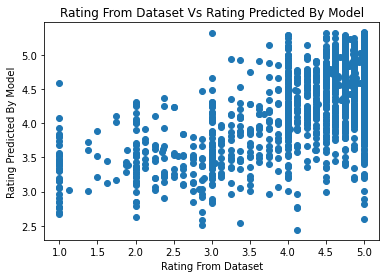

In [40]:
plt.scatter(Y_test, Y_pred)
plt.xlabel('Rating From Dataset')
plt.ylabel('Rating Predicted By Model')
plt.rcParams["figure.figsize"] = (10,6) # Custom figure size in inches
plt.title("Rating From Dataset Vs Rating Predicted By Model")

# Random Forest:

Let's fit Random forest regressor to the dataset to see if can improve the R-squared value even more:

In [41]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
  
# create regressor object
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
  
# fit the regressor with x and y data
regressor.fit(X_train, Y_train)  

RandomForestRegressor(random_state=0)

Predicting a new result:

In [42]:
Y_pred = regressor.predict(X_test)  # test the output by changing values

Reporting mean squared error and R-2 score:

In [43]:
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error = {mse}")

test_set_r2 = r2_score(Y_test, Y_pred)
print(f"R-Squared = {test_set_r2}")

Mean Squared Error = 0.5311930091091184
R-Squared = 0.44765650914942323


# Predicted against actual Y plot

Text(0.5, 1.0, 'Rating From Dataset Vs Rating Predicted By Model')

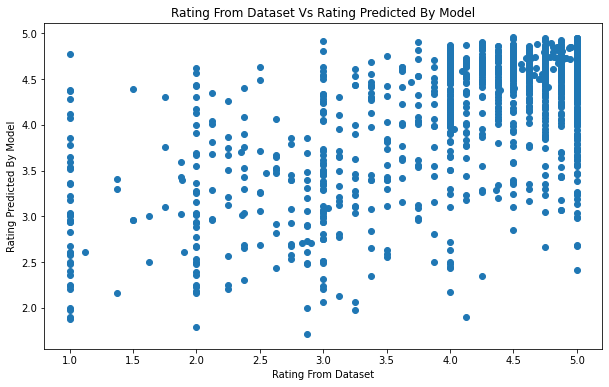

In [44]:
plt.scatter(Y_test, Y_pred)
plt.xlabel('Rating From Dataset')
plt.ylabel('Rating Predicted By Model')
plt.rcParams["figure.figsize"] = (10,6) # Custom figure size in inches
plt.title("Rating From Dataset Vs Rating Predicted By Model")

# Gradient Boosting

Let's try the Gradient Boosting here:

In [45]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, Y_train)
Y_pred = reg.predict(X_test)
print(f"Mean Squared Error = {mean_squared_error(Y_test, Y_pred)}")
print(f"R-Squared = {r2_score(Y_test, Y_pred)}")

Mean Squared Error = 0.5024629864248751
R-Squared = 0.47753047350796296


# Predicted against actual Y plot

Text(0.5, 1.0, 'Rating From Dataset Vs Rating Predicted By Model')

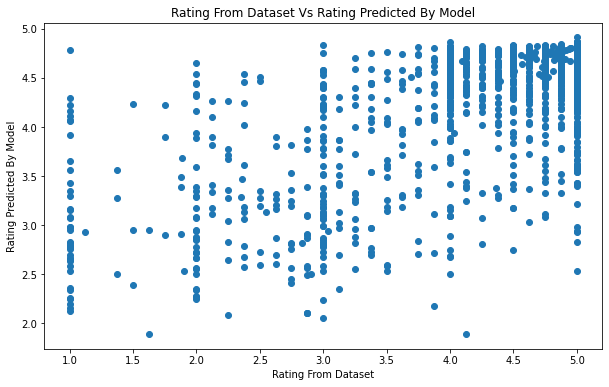

In [46]:
plt.scatter(Y_test, Y_pred)
plt.xlabel('Rating From Dataset')
plt.ylabel('Rating Predicted By Model')
plt.rcParams["figure.figsize"] = (10,6) # Custom figure size in inches
plt.title("Rating From Dataset Vs Rating Predicted By Model")

# Further Evaluations

Let's see how well the model fits the data when it comes to prediction of the Car_Make level ratings. For that we need to keep the Car_Make in our dataset datarame; fit the regression on individual reviews and then calulate the average mean squared error and R-squared in the Car_Make level:

In [47]:
pd.set_option("display.max_colwidth", 10000)
agg_merged_keywords_review_df = merged_keywords_review_df.drop_duplicates(['Review_Title','sentiment.score']).groupby(["Review_Title"]).agg({
                       'sentiment.score': 'mean',
                       'emotion.sadness': 'mean',
                       'emotion.joy': 'mean',
                       'emotion.fear': 'mean',
                       'emotion.disgust': 'mean',
                       'emotion.anger': 'mean',
                       'Rating\r': 'first',
                       'Car_Make': 'first',
                       'Review_Content': 'first'
})
agg_merged_keywords_review_df.head(10)

,sentiment.score,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,Rating\r,Car_Make,Review_Content
Review_Title,,,,,,,,,
2010 M 35 Acceleration/Braking Defects,-0.496327,0.339398,0.053823,0.143729,0.072652,0.114714,2.375,infiniti,"2010 M 35 Acceleration/Braking Defects: I leased a new 2010 M 35. This was my 9th Nissan/Infinity vehicle since 1996. This vehicle has been a huge disappointment. The vehicle has demonstrated low speed and high speed rpm increases while downs shifting. At high speeds, this is causing additional wear and tear on the drive train as evidenced by a large clanking noise. At low speeds, this is causing excess wear and tear on brakes. In both situations, it poses a safety hazard. Nissan/Infinity claims this is within the normal operating range, but the problem is significant and widespread as evidenced by Nissan/Infinity's own service people and engineers. Infinity will be forced to address this very soon or face a Toyota situation."
A Dream,-0.440443,0.145674,0.076986,0.092631,0.059397,0.172335,4.875,BMW,"A Dream: Bought this vehicle for myself with 97000 miles and fully loaded with no apparent deficits (one owner vehicle). Body, engine, paint, interior, exterior in immaculate condition. Have driven it on long and short trips and it continues to elicit stares from lexus and benz owners. This vehicle is made for driving!!"
A Wonderful Ownership Experiance,0.245085,0.113873,0.243949,0.101099,0.016000,0.117943,4.750,lincoln,"A Wonderful Ownership Experiance: Purchased the car with 20,000 miles on \rit. I drive every day and I am not \reasy on a car. My 98 Town Car \rSignature has been truly a wonderful \rcar and most of all I have had not one \rmajor problem with the car and any \rvisit to the Lincoln service \rdepartment has only given me great \rtreatment.The car is always reliable \rand built tough, I am approaching \r110,000 miles on it and I have got the \rurge to get something new, however \rthis car has been so good to me I \rdon't want to trade it for something \rwith problems. I would recomend this \rcar for anyone who desires a luxury \rride and reliability."
Best truck ever,0.969981,0.179243,0.277188,0.029521,0.014326,0.042779,5.000,Chevrolet,Best truck ever: very reliable well rounded truck.
Even better than the Chevy,-0.075949,0.098830,0.284697,0.054851,0.045185,0.044507,5.000,GMC,"Even better than the Chevy: This is the best truck I have ever \rowned. This is my first Full Size, but \rmy dad has a silverado. My GMC drives \rjust a little bit better,is a little \rbit quiter, and the exterior styling \ris the classiest out of all the trucks \rin the market. Nobody could talk me \rout of this truck and into anything \relse. Eventhough the 2004 Ford \rinterior has a good design, you still \rcouldn't pay me enough to own a FORD. \rThe editor that rated the Sierra lost \rthere mind, it should be alot higher \rthan the low 8's. The only thing I \rregret is not getting the Z71 pkg."
I LOVE MY SLK,0.926009,0.104404,0.694037,0.064407,0.036633,0.070950,5.000,mercedes-benz,I LOVE MY SLK: It is fun driving top down or up but I will srive it top down more weather permitting. It get's pretty darned hot here in Phoenix AZ in July.
I love my Caliber,0.919963,0.187137,0.604041,0.049315,0.040379,0.057248,4.750,dodge,"I love my Caliber: I just bought my Caliber this week So far it has been a blast to drive. I was so surprised how much pep it's got for a small engine. It's also very smooth, you don't even feel the gear shift, I love that. I also love the way it feels like an SUV but looks like a sporty car. So far I love everything about it."
Looks Good But Hunk Of Junk,-0.999568,0.441097,0.283959,0.173938,0.097350,0.158059,2.875,maserati,"Looks Good But Hunk Of Junk: This car is strictly ""looks only"", it is not reliable or even close to it.I have already sank $13,760 in repairs at only 23K miles.This is totally unacceptable for a $140K car when new.I am taking it to the auction next week to 

In [48]:
train_set = agg_merged_keywords_review_df.sample(frac=0.75, random_state=0)
test_set = agg_merged_keywords_review_df.drop(train_set.index)

In [49]:
train_set.groupby("Car_Make").size()

Car_Make
AMGeneral          3
Acura            137
AlfaRomeo         58
AstonMartin       65
Audi             141
BMW              149
Bentley          101
Bugatti            8
Buick            132
Cadillac         157
Chevrolet        146
GMC              145
Honda            147
Toyota           145
Volkswagen       140
chrysler         127
dodge            142
ferrari          119
fiat             136
ford             142
genesis           56
hummer           144
hyundai          130
infiniti         130
isuzu            131
jaguar           126
jeep             131
kia              127
lamborghini       60
land-rover       145
lexus            133
lincoln          133
lotus             97
maserati         139
maybach           11
mazda            146
mercedes-benz    129
mercury          126
mini             143
mitsubishi       128
nissan           127
pontiac          127
porsche          140
ram              132
rolls-royce       18
subaru           138
suzuki           116
tesl

In [50]:
X_train = train_set.dropna().iloc[:, :6].values.reshape(-1, 6)  # values converts it into a numpy array
X_test = test_set.dropna().iloc[:, :6].values.reshape(-1, 6)  # values converts it into a numpy array
Y_train = train_set.dropna()['Rating\r'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
Y_test = test_set.dropna()['Rating\r'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column

In [51]:
reg = GradientBoostingRegressor(random_state=0)  # create object for the class
reg.fit(X_train, Y_train)  # fit the model on the training data
Y_pred = reg.predict(X_test) # make predictions

In [52]:
test_set['Predicted_Y'] = Y_pred

In [53]:
agg_grouped_test_set = test_set.groupby('Car_Make').agg(['mean'])
agg_grouped_test_set

,sentiment.score,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,Rating\r,Predicted_Y
,mean,mean,mean,mean,mean,mean,mean,mean
Car_Make,,,,,,,,
AMGeneral,-0.594638,0.240532,0.020233,0.209863,0.148217,0.280780,3.000000,3.194602
Acura,0.146076,0.216153,0.310447,0.112656,0.088328,0.118972,4.209746,4.227164
AlfaRomeo,0.160632,0.232433,0.315023,0.125210,0.082053,0.122382,4.388889,4.322972
AstonMartin,0.400920,0.201064,0.362957,0.114105,0.061657,0.115535,4.326087,4.448320
Audi,0.252668,0.195495,0.330413,0.106549,0.059369,0.103690,4.445755,4.365891
BMW,0.159408,0.194169,0.368360,0.120398,0.061844,0.123578,4.513889,4.293852
Bentley,0.307778,0.172982,0.371687,0.110235,0.078887,0.130370,4.229730,4.410651
Bugatti,-0.111498,0.147069,0.482210,0.122855,0.072881,0.097407,4.250000,4.382092


In [54]:
# To get the number of reviews per Car Name:
test_set.groupby('Car_Make').nunique()

,sentiment.score,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,Rating\r,Review_Content,Predicted_Y
Car_Make,,,,,,,,,
AMGeneral,2,2,2,2,2,2,2,2,2
Acura,59,59,59,59,59,59,21,59,58
AlfaRomeo,18,18,18,18,18,18,4,18,18
AstonMartin,23,23,23,23,23,23,12,23,23
Audi,53,53,53,53,53,53,16,53,52
BMW,45,45,45,45,45,45,12,45,45
Bentley,37,37,37,37,37,37,13,37,37
Bugatti,1,1,1,1,1,1,1,1,1
Buick,59,59,59,59,59,59,18,59,55


In [55]:
# r2_score for predicted y and target y avg per group!
agg_r2_score = r2_score(agg_grouped_test_set['Rating\r'], agg_grouped_test_set['Predicted_Y'])
print(f"R-Squared = {agg_r2_score}")
agg_mse = mean_squared_error(agg_grouped_test_set['Rating\r'], agg_grouped_test_set['Predicted_Y'])
print(f"Mean Squared Error = {agg_mse}")

R-Squared = 0.8021197630035817
Mean Squared Error = 0.016904870283648715


As the mean_squared error shows when it comes to the average the model has fitted the data moderately well. The R-squareds shows a moderate effect size indicates that ~44% of the variability in the Rating cannot be explained by the model.

In [56]:
agg_grouped_test_set[['Rating\r', 'Predicted_Y']]

,Rating\r,Predicted_Y
,mean,mean
Car_Make,,
AMGeneral,3.000000,3.194602
Acura,4.209746,4.227164
AlfaRomeo,4.388889,4.322972
AstonMartin,4.326087,4.448320
Audi,4.445755,4.365891
BMW,4.513889,4.293852
Bentley,4.229730,4.410651
Bugatti,4.250000,4.382092


y = 0.71x + 1.24


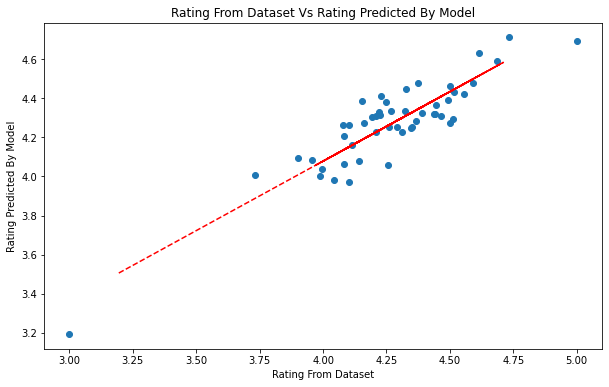

In [57]:
import matplotlib.pylab as pylab

# plot the data itself
pylab.plot(agg_grouped_test_set['Rating\r'],agg_grouped_test_set['Predicted_Y'],'o')
pylab.xlabel('Rating From Dataset')
pylab.ylabel('Rating Predicted By Model')

# calc the trendline
z = np.polyfit(np.squeeze(agg_grouped_test_set['Rating\r']), np.squeeze(agg_grouped_test_set['Predicted_Y']), 1)
p = np.poly1d(z)
pylab.plot(agg_grouped_test_set['Predicted_Y'],p(agg_grouped_test_set['Predicted_Y']),"r--")
pylab.title("Rating From Dataset Vs Rating Predicted By Model")
# the trendline equation:
print ("y = %.2fx + %.2f"%(z[0],z[1]))

The above results suggest a clear better fit for the model in average; showing that the Gradient Boosting Regressor model explains 74% of the fitted Car Make level Rating in the regression model.

# Conclusion

In this notebook we demonstrated how Text Extensions for Pandas can be used to perform Sentiment Analysis tasks. We started by loading our car reviews and passing it through Watson NLU service. We extracted the keywords and their corresponding sentiment and fine-grained emotion using the Watson NLU service. We used Text Extensions for Pandas to convert the Watson NLU output to pandas dataframe and calculated the reveiw-level sentiment and emotion. Using the resulted Pandas dataframe, we showed the correlation of Watson NLU's extracted features and user's Rating first and then developed the Univariate/Multivariate Regression, Random Forest, and Gradient Boosting models for predicting the Ratings for a given review. Finally we evaluated the ability of the model for predicting the sentiment for each car make.

This notebook also demonstrates how easy it is to use IBM Watson NLU, Pandas, Scikit Learn together to conduct exploratory analysis or predcition on your data.